# Install Packages

In [405]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_v2_behavior()
print(tf.__version__)

import numpy as np

tf.get_logger().setLevel('ERROR')

2.15.0


Install TensorFlow Privacy.

In [406]:
!pip install tensorflow-privacy

In [407]:
!pip install imutils
from imutils import paths

# Mount Google Drive


In [408]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [409]:
!ls /content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet
mnist_path ='/content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet'

0  1  2  3  4  5  6  7	8  9


# Create Clients

In [410]:
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# Global Setting

In [411]:
batch_size = 30
TOTAL_CLIENTS = 100
comms_round = 20
FREELOADERS = True
COLLUDERS = False
MK_CHOICE = 'MKK'
PERCENT_FREELOADERS = 0.5
frac = 0.3 # fraction of Byzantine Trainers

In [412]:

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
#     random.shuffle(data)  # <- IID

    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients

    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

def batch_data(data_shard, bs=batch_size, flip=False):
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    data = np.array(data)

    labels = list(label)

    if flip:
        labels = shuffle(labels)

    labels = np.array(labels)
    data = np.array(list(data))

    assert(data.shape[0] == labels.shape[0])

#     data = tf.constant(data)
#     labels = tf.constant(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))

    X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data,
                                                    label,
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_train)), np.array(list(y_data_train))))
    test_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_test)), np.array(list(y_data_test))))
    return (train_dataset.shuffle(len(y_data_train)).batch(bs), test_dataset.batch(bs), y_data_test)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs


    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)

    return local_count/global_count

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights



def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('round/client: {} | acc: {:.3%} | loss: {}'.format(comm_round, acc, loss))
    return acc, loss

# Create Model

In [413]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

class SimpleMLP:

    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes, use_bias=True, name="last_dense"))
        model.add(Activation("softmax"))
        return model


In [414]:
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [415]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28*28)
test_data = test_data.reshape(test_data.shape[0], 28*28)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

train_data.shape, train_labels.shape

((60000, 784), (60000, 10))

In [416]:
X_train, X_test, y_train, y_test = train_data, test_data, train_labels, test_labels

In [417]:
len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

In [418]:
clients = create_clients(X_train, y_train, num_clients=TOTAL_CLIENTS, initial='client')

In [419]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

# Heatmap of non-IID data

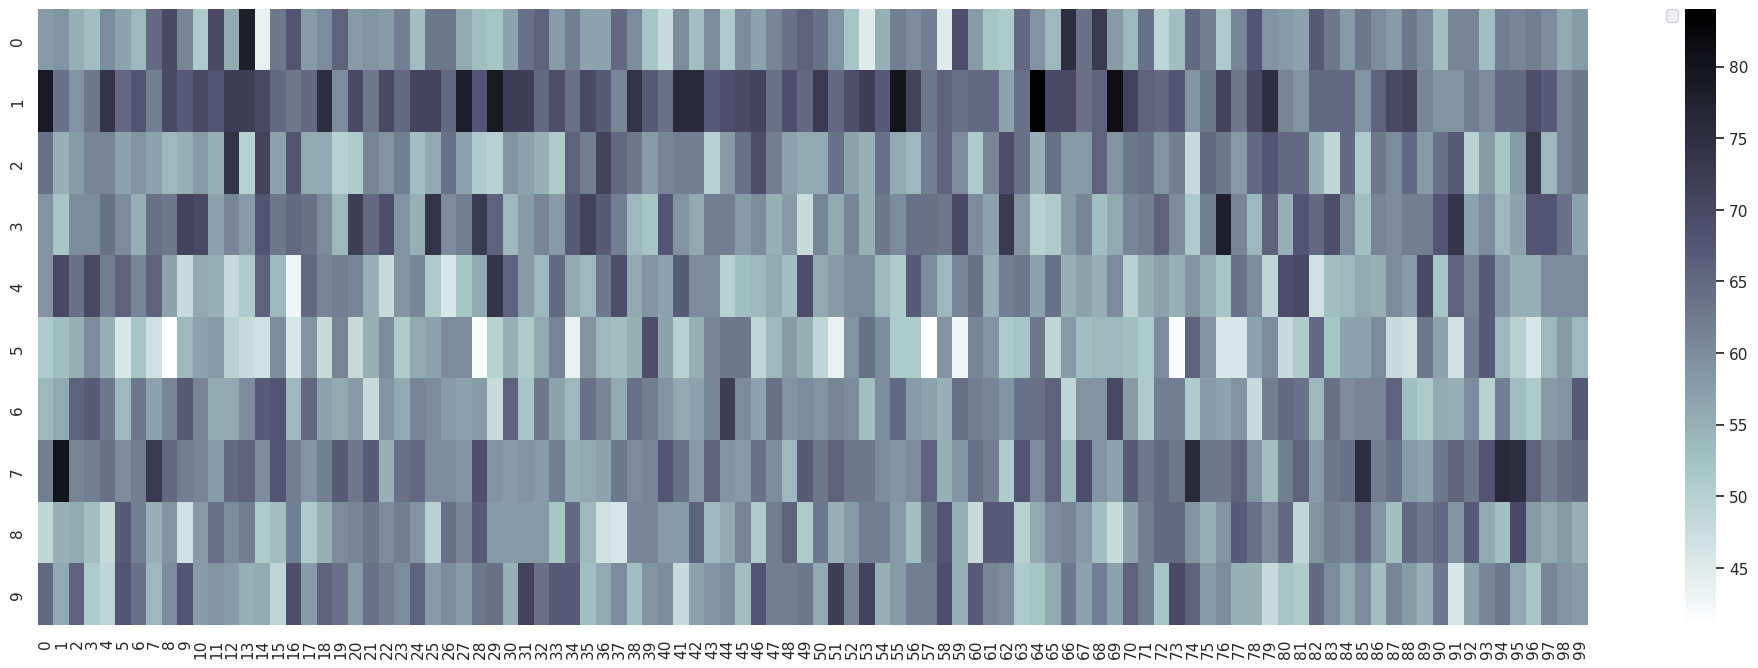

In [420]:
from collections import Counter
import seaborn as sns

def one_hot_to_numbers(labels):
    numbers = []
    for one_hot in labels:
        number = np.argmax(one_hot)
        numbers.append(number)
    return numbers

def number_count_tuples(numbers):
    count_dict = dict(Counter(numbers))
    count_tuples = [(number, count) for number, count in count_dict.items()]
    return count_tuples

distrib = [[0]*TOTAL_CLIENTS for _ in range(10)]
client_id = 0
for client_name in clients.keys():
    client_data = clients[client_name]
    _, labels = zip(*client_data)
    numbers = one_hot_to_numbers(labels)
    count_tuples = number_count_tuples(numbers)

    for item in count_tuples:
        distrib[item[0]][client_id] = item[1]

    client_id += 1

    distrib = np.array(distrib)
# print(distrib)
sns.set(rc={'figure.figsize':(25,8)})
sns.heatmap(distrib, cmap='bone_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
# plt.savefig("heatmap.png")

# Create byzantine participants

In [421]:
BYZANTINE_CNT = int(frac*TOTAL_CLIENTS)

In [422]:
PRIVATIZE = False

# FedAvg

In [423]:
import random
from sklearn.utils import shuffle

#process and batch the training data for each client
# and pick one owner that is not byzantine
client_names = list(clients.keys())
owner_idx = random.randint(0,len(client_names))
owner_name = client_names[owner_idx]

clients_batched = dict()
flipped = []
for (client_name, data) in clients.items():
    flip = True if client_name != owner_name and random.randint(0,TOTAL_CLIENTS) < BYZANTINE_CNT else False
    if flip:
        flipped.append(client_name)
    clients_batched[client_name] = batch_data(data, flip=flip)

print('flipped:', len(flipped))

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((np.array(list(X_test)), np.array(list(y_test)))).batch(len(y_test))

flipped: 31


In [424]:
# FedAvg for complete weights

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''

    avg_grad = tf.math.reduce_sum(weight_list, axis=0)
    avg_grad = tf.multiply(layer_mean, 1/len(weight_list))

    return avg_grad

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights

# Bias Detect

In [425]:
# Efficient Detection of Byzantine Attacks in
# Federated Learning using Last Layer Biases

from scipy.spatial.distance import cdist
from scipy.optimize import minimize

def get_distances_from_geomed(geomed, points):
    return cdist([geomed], points)

# median absolute deviation (MAD)
def compute_mad(update, update_length):
    m = np.median(update)
    mad = 0
    for i in range(update_length):
        mad+=abs(update[i]-m)

    return mad/update_length

def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem. refers to the point in a multidimensional space that minimizes the sum of distances
    to a set of other points. It can be modeled as a convex optimization problem, where the objective function is the sum of distances
    from the candidate solution to the set of points, and the constraints are the bounds on the dimensions of the solution.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)
#     print(centroid)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia. It's a numerical method
    for finding the geometric median of a set of points in a Euclidean space.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

def geometric_median(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def get_honest_workers(distances_from_geomed):
    """
    the function sets the tolerance level to be 1.5 times the maximum value of the first m distances, where m is half of the number of workers plus one.
    This tolerance value is used to assign scores to the workers. If the distance between two consecutive workers is greater than the tolerance,
    the scores for the workers with higher distances are set to zero.

    The scores assigned to the workers are then sorted according to the original indices of the workers.
    A median of the distances from the geometric median is then computed, and workers with distances less than or equal to the median are assigned scores of 1.

    Finally, the function returns the indices of the workers who have scores of 1 and the list of scores for all workers as two separate outputs.
    """

    distances_from_geomed = np.asarray(distances_from_geomed)
    indices = distances_from_geomed.argsort()
    sorted_distances = np.asarray(sorted(distances_from_geomed))

    n = len(sorted_distances)
    between_distances = np.zeros(n)
    for i in range(1, n):
        between_distances[i] = sorted_distances[i]-sorted_distances[i-1]

    m = int(n/2)+1
    tolerance = max(between_distances[:m+1])*1.5
    scores = np.ones(n)
    for i in range(m, n):
        if between_distances[i] > tolerance:
            scores[i:] = 0
            break
    sorted_scores = np.empty_like(scores)

    for i, idx in enumerate(indices):
        sorted_scores[idx] = scores[i]

    scores = sorted_scores
    median = np.percentile(distances_from_geomed, [60])
    for i in range(n):
        if distances_from_geomed[i]<=median:
            scores[i] = 1

    honest_workers = [i for i, x in enumerate(scores) if x]

    return honest_workers, list(scores)

def assess_workers(client_layer_tuples):
    clients = [item[0] for item in  client_layer_tuples]
    last_layer_biases = [item[1][1] for item in  client_layer_tuples]
    # median absolute deviation (MAD)
    mad_biases = [compute_mad(last_layer_biases[i].flatten(), 10) for i in range(len(last_layer_biases))]
#     print('MAD biases', mad_biases)
    geomed = geometric_median(last_layer_biases, method='auto')
#     print('GeoMed ', geomed)
    distances_from_geomed = get_distances_from_geomed(geomed, last_layer_biases)[0]
#     print('Distances from geomed ', distances_from_geomed)
    honest_workers, scores = get_honest_workers(distances_from_geomed)
    honest_workers = [clients[i] for i in honest_workers]
    dishonest_workers = []

    for i in range(len(clients)):
        if scores[i] == 0:
            dishonest_workers.append(clients[i])

    return honest_workers, dishonest_workers, scores

# Multi-Krum

In [426]:
import numpy as np

def score(weights, trainers):
    R = len(weights)
    score_matrix = np.zeros((R, R))

    for i in range(R):
        for j in range(i + 1, R):
            diff = np.subtract(weights[i], weights[j])
            l2_norm = np.sqrt(np.sum(np.square(diff)))
            score_matrix[i, j] = l2_norm
            score_matrix[j, i] = l2_norm

    # Compute the median of distances for each trainer
    scores = np.median(score_matrix, axis=0)

    # Get the indices that would sort the scores array
    sorted_indices = np.argsort(scores)

    # Use these indices to reorder the trainers and scores
    sorted_trainers = [trainers[i] for i in sorted_indices]
    sorted_scores = scores[sorted_indices]

    return sorted_trainers, sorted_scores.tolist()


# GPU implementation
def _score(weights, trainers):
    weights = tf.convert_to_tensor(weights, dtype=tf.float64)  # Ensure weights are TensorFlow tensors
    R = tf.shape(weights)[0]

    # Expand weights for broadcasting and compute pairwise L2 norms
    w_expanded_1 = tf.expand_dims(weights, 1)
    w_expanded_2 = tf.expand_dims(weights, 0)
    diff = w_expanded_1 - w_expanded_2
    l2_norms = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=2))

    # Mask self-comparisons by setting them to infinity
    mask = tf.eye(R, dtype=tf.bool)
    l2_norms_masked = tf.where(mask, tf.fill(tf.shape(l2_norms), tf.constant(float('inf'), dtype=tf.float64)), l2_norms)

    # Compute median for each column (trainer)
    medians = tf.linalg.tensor_diag_part(tf.nn.top_k(l2_norms_masked, k=R//2+1, sorted=True).values)
    if R % 2 == 1:
        scores = medians[:, R//2]
    else:
        scores = (medians[:, R//2 - 1] + medians[:, R//2]) / 2.0

    # Get the indices that would sort the scores array
    sorted_indices = tf.argsort(scores)

    # Use these indices to reorder the trainers and scores
    sorted_trainers = tf.gather(trainers, sorted_indices)
    sorted_scores = tf.gather(scores, sorted_indices)

    return sorted_trainers.numpy().tolist(), sorted_scores.numpy().tolist()

# MK implementation
def _multikrum_selected_trainers_MK(local_weight_tuples):

    weights = [item[1] for item in local_weight_tuples]
    trainers = [item[0] for item in local_weight_tuples]

    trainers, scores = score(weights, trainers)

    # Pair each trainer with their score
    trainer_scores = list(zip(trainers, scores))

    # Sort by scores in ascending order
    sorted_trainer_scores = sorted(trainer_scores, key=lambda x: x[1])

    # Determine cutoff for honest/dishonest separation
    cutoff_index = len(sorted_trainer_scores) - len(sorted_trainer_scores) // 3
    honest_trainer_scores = sorted_trainer_scores[:cutoff_index]
    dishonest_trainer_scores = sorted_trainer_scores[cutoff_index:]

    # Unpack trainers and scores for honest and dishonest separately
    honest_trainers, honest_scores = zip(*honest_trainer_scores)
    dishonest_trainers, _ = zip(*dishonest_trainer_scores) if dishonest_trainer_scores else ([], [])

    return list(honest_trainers), list(dishonest_trainers), list(honest_scores)

from sklearn.cluster import KMeans

def penalize_freeriders(trainers, scores):
  score_count = {score: scores.count(score) for score in scores}
  freeriders = []
  unique_trainers = []
  unique_scores = []

  # Identify freeriders and prepare lists of unique trainers and scores
  for trainer, score in zip(trainers, scores):
      if score_count[score] > 1:
          # This trainer's score appears more than once, mark as freerider
          freeriders.append(trainer)
      else:
          # This trainer has a unique score, keep in the final lists
          unique_trainers.append(trainer)
          unique_scores.append(score)

  return unique_trainers, unique_scores, freeriders

# MKK implementation
def _multikrum_selected_trainers_MKK(local_weight_tuples):
    weights = [item[1] for item in local_weight_tuples]
    trainers = [item[0] for item in local_weight_tuples]

    # Assuming 'score' function calculates scores for each trainer based on 'weights'
    trainers, scores = score(weights, trainers)
    trainers, scores, freeriders = penalize_freeriders(trainers, scores)

    # Apply K-means clustering to classify trainers based on scores
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(scores).reshape(-1, 1))
    labels = kmeans.labels_

    # Determine which cluster has the higher average score
    cluster_0_indices = [i for i, label in enumerate(labels) if label == 0]
    cluster_1_indices = [i for i, label in enumerate(labels) if label == 1]

    cluster_0_avg_score = np.mean([scores[i] for i in cluster_0_indices])
    cluster_1_avg_score = np.mean([scores[i] for i in cluster_1_indices])

    # Assume the cluster with the higher average score is potentially dishonest
    dishonest_cluster = 0 if cluster_0_avg_score > cluster_1_avg_score else 1

    honest_trainers = [trainers[i] for i, label in enumerate(labels) if label != dishonest_cluster]
    dishonest_trainers = [trainers[i] for i, label in enumerate(labels) if label == dishonest_cluster] + freeriders

    honest_scores = [scores[i] for i, label in enumerate(labels) if label != dishonest_cluster]
    dishonest_scores = [scores[i] for i, label in enumerate(labels) if label == dishonest_cluster] + [0]*len(freeriders)

    return honest_trainers, dishonest_trainers, honest_scores

if MK_CHOICE == "MK":
  multikrum_selected_trainers = _multikrum_selected_trainers_MK
elif MK_CHOICE == "MKK":
  multikrum_selected_trainers = _multikrum_selected_trainers_MKK
else:
  raise ValueError("Invalid MK_CHOICE. Must be either 'MK' or 'MKK'.")



In [427]:
# unit test
weights = [
    np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 1022, 23, 24, 25]], dtype=np.float64),
    np.array([[5, 4, 3, 2, 1], [10, 9, 8, 7, 6], [15, 14, 13, 12, 11], [20, 19, 18, 17, 16], [25, 24, 23, 22, 21]], dtype=np.float64),
    np.array([[5, 4, 3, 2, 1], [10, 9, 8, 7, 6], [15, 14, 13, 12, 11], [20, 19, 18, 17, 16], [25, 24, 23, 22, 21]], dtype=np.float64), # duplicate of previous one
    np.array([[2, 3, 4, 5, 6], [7, 8, 9, 10, 11], [12, 13, 14, 15, 16], [17, 18, 19, 20, 21], [22, 23, 24, 25, 26]], dtype=np.float64),
    np.array([[6, 5, 4, 3, 2], [11, 10, 9, 8, 7], [16, 15, 14, 13, 12], [21, 20, 19, 18, 17], [26, 25, 24, 23, 22]], dtype=np.float64),
    np.array([[12, 32, 5, 7, 9], [11, 13, 15, 17, 19], [21, 23, 257, 27, 29], [2, 4, 6, 8, 10], [12, 14, 16, 18, 20]], dtype=np.float64),
    np.array([[9, 7, 5, 3, 1], [19, 17, 15, 13, 11], [29, 27, 25, 23, 21], [10, 8, 6, 4, 2], [20, 18, 16, 14, 12]], dtype=np.float64),
    np.array([[5, 105, 15, 20, 25], [30, 35, 402, 45, 50], [55, 1, 65, 70, 75], [78, 5, 90, 95, 34], [105, 1, 1, 120, 1]], dtype=np.float64),
    np.array([[25, 20, 152, 10, 5], [50, 45, 40, 35, 30], [75, 70, 9, 60, 55], [7, 95, 90, 85, 80], [2, 120, 115, 3, 105]], dtype=np.float64),
    np.array([[10, 20, 1, 401, 50], [60, 70, 80, 90, 100], [110, 120, 130, 140, 150], [160, 2, 180, 190, 200], [210, 220, 230, 240, 250]], dtype=np.float64),
    np.array([[50, 40, 304, 20, 10], [100, 2, 80, 70, 60], [7, 140, 8, 120, 110], [200, 190, 3, 170, 160], [250, 0, 230, 0, 210]], dtype=np.float64)
]

trainers = [f"trainer{i+1}" for i in range(len(weights))]

# Compute scores
trainers, scores = score(weights, trainers)

# Pair the trainers with their corresponding weights
local_weight_tuples = list(zip(trainers, weights))

# Testing multikrum_selected_trainers
honest_trainers, dishonest_trainers, honest_scores = multikrum_selected_trainers(local_weight_tuples)

# Printing the results of the test
print("Honest Trainers: ", honest_trainers)
print("Dishonest Trainers: ", dishonest_trainers)
print("Scores of Honest Trainers: ", honest_scores)

Honest Trainers:  ['trainer9', 'trainer2', 'trainer6', 'trainer11', 'trainer8']
Dishonest Trainers:  ['trainer1', 'trainer10', 'trainer7', 'trainer4', 'trainer3', 'trainer5']
Scores of Honest Trainers:  [234.89997871434556, 248.74283909290736, 249.13650876577685, 297.72134622831464, 464.1540692485632]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Bristle

In [428]:
# Bristle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from statistics import stdev
import math

def build_model():
  model = SimpleMLP.build(784, 10)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model



def freeze_all_except_out(model):
    for layer in global_model.layers[:-2]:
        layer.trainable=False

def unfreeze_all_layers(model):
    for layer in global_model.layers:
        layer.trainable=True

def get_last_dense_layer_weights(model):
    return model.get_weights()[-2]

def weight_sigmoid(omega1, omega2, disc, certainty):
    return max(0, omega1/(1 + math.exp(-disc/100)) - omega2)*certainty

def compute_fa_fo_wg(my_detailed_f1, detailed_f1, fi=10, mu=0.9, omega_fa1=0.99, omega_fa2=0.1, omega_fo1=0.5, omega_fo2=0.5):
    disc = [0]*len(my_detailed_f1)
    fa_wg = [0]*len(my_detailed_f1)
    fo_columns = [0]*len(my_detailed_f1)

    best = sorted(detailed_f1, reverse=True)[:fi]
    certainty = max(sum(best)/len(best) - stdev(best), 0) if len(best) > 0 else 0

    for c in range(len(my_detailed_f1)):
        if detailed_f1[c] > 0 and my_detailed_f1[c] == 0:
            fo_columns[c] == 1

        weighed_diff = (detailed_f1[c] - my_detailed_f1[c])*mu
        if detailed_f1[c] > my_detailed_f1[c]:
            disc[c] = weighed_diff**(3 + my_detailed_f1[c])
        else:
            disc[c] = -math.inf #-1*pow(weighed_diff, 4 + int(my_detailed_f1[c]))

        fa_wg[c] = weight_sigmoid(omega_fa1, omega_fa2, disc[c], certainty)

    fo_wg = weight_sigmoid(omega_fo1, omega_fo2, sum(disc), certainty)
    return fa_wg, fo_wg, fo_columns

def layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list):
    class_cnt = len(my_layer[0])
    my_new_layer = copy.deepcopy(my_layer)
    total_weights = [1]*class_cnt
    for i in range(len(layer_list)):
        for c in range(class_cnt):
            my_new_layer[0][c] = my_layer[0][c] + layer_list[i][0][c]*fa_wg_list[i][c]
            total_weights[c] += fa_wg_list[i][c]

    for c in range(class_cnt):
        my_new_layer[0][c] = my_new_layer[0][c]/total_weights[c]

    return my_new_layer

In [429]:
def calc_F1(test_data_tf,  y_local_test, model, labels = [0,1,2,3,4,5,6,7,8,9], logits = None, fi=10):
    if logits == None:
        logits = model.predict(test_data_tf)

    detailed_f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average=None, labels=labels, zero_division=1)
    f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average='macro', labels=labels, zero_division=1)

    return f1, detailed_f1

In [430]:
def weighed_aggretate(weight_list, factors = []):
    if factors == []:
        factors = [1]*len(weight_list)

    for i in range(len(weight_list)):
        weight_list[i] = scale_model_weights(weight_list[i], factors[i]/sum(factors))

    return sum_scaled_weights(weight_list)

# Local Training

In [431]:
import random
global_weights_hist =[]

def local_train(client, global_model, local_model, local_rounds = 3, byzantine=False):
    new_weights = copy.copy(global_model.get_weights())
    global_weights_hist.append(new_weights)

    if byzantine:
      if FREELOADERS and random.random() <= PERCENT_FREELOADERS:
        if len(global_weights_hist) > 1:
          local_model.set_weights(global_weights_hist[len(global_weights_hist) - 2])
          return
    else:
        local_model.set_weights(new_weights)
    train_ds, test_ds, _ = clients_batched[client]
    local_model.fit(train_ds, epochs=local_rounds, verbose=False)

In [432]:
def has_foreign_classes(my_f1, other_f1):
    for i in range(len(my_f1)):
        if my_f1[i] == 0 and other_f1[i] > 0:
            return True
    return False

In [433]:
def local_rank(model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1, count = 10, min_f1 = .1, exclude_foreign_classes = False):
    f1_list = []
    f1_detailed_list = []
    layer_list = []
    client_list = []

    honest, dishonest, _ = assess_workers(client_layer_tuples)

    for client_tuple in client_layer_tuples:
        if client_tuple[0] in dishonest:
            continue

        model = reconstruct_model(model.get_weights(), client_tuple[1])
        f1, detailed_f1 = calc_F1(test_data_tf, y_local_test, model)

        if exclude_foreign_classes and has_foreign_classes(my_detailed_f1, detailed_f1):
            continue
        if f1 < min_f1:
            continue

        f1_list.append(f1)
        f1_detailed_list.append(detailed_f1)
        layer_list.append(layer)
        client_list.append(client_tuple[0])

#     indexes = sorted(range(len(f1_list)), key=lambda i: f1_list[i])[-count:]
    indexes = [i[0] for i in sorted(enumerate(f1_list), key=lambda x:x[1], reverse=True)] #[:-count]
    return [f1_list[x] for x in indexes], [f1_detailed_list[x] for x in indexes], [layer_list[x] for x in indexes], [client_list[x] for x in indexes]

# Utils

In [434]:
def reconstruct_model(base_model_weights, last_dense_layer):
    model = build_model()
    base_model_weights[-2] = np.array(last_dense_layer)
    model.set_weights(base_model_weights)
    return model

In [435]:
def integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test):
    my_model = reconstruct_model(global_model.get_weights(), my_layer)
    my_f1, my_detailed_f1 = calc_F1(test_data_tf, y_local_test, my_model)
    f1_list, detailed_f1_list, layer_list, client_list = local_rank(my_model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1)
    fa_wg_list = []
    fo_wg_list = []
    fo_columns_list = []

    for j in range(len(layer_list)):
        fa, fo, fo_columns = compute_fa_fo_wg(my_detailed_f1, detailed_f1_list[j], fi=15, mu=0.9, omega_fa1=1.0, omega_fa2=0.0001, omega_fo1=0.99, omega_fo2=0.0001)
        fa_wg_list.append(fa)
        fo_wg_list.append(fo)
        fo_columns_list.append(fo_columns)
    my_new_layer = layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list)

    return my_new_layer, client_list

def bristle_integrate_classes_all(client_layer_tuples):
    new_local_layer_list = []
    client_selection_list = list()

    for i in range(len(client_layer_tuples)):
        my_layer = client_layer_tuples[i][1]
        _, test_data_tf,  y_local_test = clients_batched[client_names[i]]
        my_new_layer, client_list = integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test)
        new_local_layer_list.append(my_new_layer)
        client_selection_list.append(client_list)
    return new_local_layer_list, client_selection_list

def bristle_client_ranks(client_selection_list):
    rank_map ={}

    for row in client_selection_list:
        for col in row:
            rank_map[col] = rank_map.get(col, 0) + 1

    return rank_map

In [436]:
global_comm_rounds = 1
local_comm_rounds = 10

In [437]:
from enum import Enum

class Method(Enum):
    BRISTLE = 1
    MULTIKRUM = 2
    BIAS_DETECT = 3
    CLEAN = 4

method = Method.MULTIKRUM

Logging Util

In [438]:
import json
from pathlib import Path
from datetime import datetime
import os

log_file=f'/content/drive/MyDrive/kaggle/logs_{method}_{MK_CHOICE}_{frac}_{datetime.now()}.json'

def log_init(filename=log_file):
    with open(filename,'w+') as file:
        file_data = {'run_logs': []}
        json.dump(file_data, file, indent = 4)

def write_json(new_data, filename=log_file):
    with open(filename,'r+') as file:
        file_data = json.load(file)
        file_data['run_logs'].append(new_data)
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

def json_log(tr, hw, dhw, ahw, adhw, aw):
    data = {
        "tr": tr,
        "hw": hw,
        "dhw": dhw,
        "ahw": ahw,
        "adhw": adhw,
        "aw": aw
    }
    write_json(data)
    print('dhw', dhw, 'adhw', adhw)

log_file

'/content/drive/MyDrive/kaggle/logs_Method.MULTIKRUM_MKK_0.3_2024-03-30 23:35:56.227709.json'

# New Section

In [439]:
tf.__version__

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 30
learning_rate = 0.25

print(batch_size, num_microbatches)

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


# Select your differentially private optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

30 30


# The Main Loop

In [440]:
import pandas as pd
import copy
from sklearn.metrics import accuracy_score

global_model = SimpleMLP.build(784, 10)
global_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

global_loss_list = []
global_acc_list = []
client_models = {}
# privatizer = Gaussian()
log_init()


for global_round in range(global_comm_rounds):
    print('Global round', global_round)
#     unfreeze_all_layers(global_model)
    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())

    client_names = random.sample(all_client_names, k=TOTAL_CLIENTS)
    if owner_name in client_names:
        client_names.remove(owner_name)

    random.shuffle(client_names)
    ranks_df = pd.DataFrame(columns=client_names)

    byzantine_selected = [client_name for client_name in flipped if client_name in client_names]
#     sum([1 if client_name in flipped else 0 for client_name in client_names ])

    def mark_byzantine(client):
        if client in byzantine_selected:
            return "{}{}".format(client, '*')
        else:
            return client


    print('byzantine count', len(byzantine_selected))

    # owner must not be Byzantine
    train_ds, _, _ = clients_batched[owner_name]
    global_model.fit(train_ds, epochs=10, verbose=True)

    if method == Method.BRISTLE:
        freeze_all_except_out(global_model)


    #commence global training loop
    for comm_round in range(comms_round):
        print('Round:', comm_round)
        #initial list to collect local model weights after scalling
        client_layer_tuples = list()
        local_weight_tuples = list()
        client_bias = list()

        #loop through each client and create new local model
        # and publish weights to IPFS

        for client in client_names:
            print('round', comm_round, 'client', client)
            if client not in client_models.keys():
                local_model = SimpleMLP.build(784, 10)
                local_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                client_models[client] = local_model

            local_model = client_models[client]

            local_train(client, global_model, local_model, local_comm_rounds, byzantine=(client in byzantine_selected))
            layer = get_last_dense_layer_weights(local_model)

#             if client in byzantine_selected:
#                 # shuffle around weights if byzantine
#                 random.shuffle(layer[0])
#                 random.shuffle(layer[1])


            # Apply gaussian differential privacy to last layer
            if PRIVATIZE:
                layer = privatizer.privatize_out(layer)

            client_layer_tuples.append((client, layer))

            if method != Method.BRISTLE:
                local_weight_tuples.append((client, local_model.get_weights()))

            # K.clear_session()

        # the following is either performed by clients and accepted by SC on a majority-basis
        # or performed by SC. Downside of the latter is that the last accepted Trainer gets penalized, as processing may be costly
        honest_workers, dishonest_workers, scores = multikrum_selected_trainers(client_layer_tuples) #
        alt_honest_workers, alt_dishonest_workers, alt_scores = assess_workers(client_layer_tuples)

        json_log(comm_round,
                 [mark_byzantine(client) for client in honest_workers],
                 [mark_byzantine(client) for client in dishonest_workers],
                 [mark_byzantine(client) for client in alt_honest_workers],
                 [mark_byzantine(client) for client in alt_dishonest_workers],
                 [f'{cn}{"*"}' if cn in byzantine_selected else cn for cn in client_names]
        )

        if method == Method.BRISTLE:
            # Each Trainer does the Bristle integration with the rest of the models
            # that revealed their IPFS locations
            new_local_layer_list, client_selection_list = bristle_integrate_classes_all(client_layer_tuples)
            rank_map = bristle_client_ranks(client_selection_list)
            ranks_df = ranks_df.append(rank_map, ignore_index=True)

            for client in rank_map.keys():
                print(client, "*" if client in byzantine_selected else " ", rank_map[client])

            # Aggregator computes last dense layer
            last_dense_layer = weighed_aggretate(new_local_layer_list)

        #update global model.

        if method == Method.BRISTLE:
            global_model = reconstruct_model(global_model.get_weights(), last_dense_layer)
        else:
            assert(len(honest_workers) > 0)
            local_weight_list = []

            for (client, weights) in local_weight_tuples:
                scaled_weights = []
                if method in [Method.MULTIKRUM, Method.BIAS_DETECT]:
                    if method == Method.BIAS_DETECT:
                        honest_workers = alt_honest_workers

                    if client in honest_workers:
                        # scaled_weights = scale_model_weights(weights, 1/len(honest_workers))
                        local_weight_list.append(weights)
                else:
                    # scaled_weights = scale_model_weights(weights, 1/len(local_weight_tuples))
                    local_weight_list.append(weights)

            average_weights = fed_avg(local_weight_list)
            global_model.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
            global_acc_list.append(global_acc)
            global_loss_list.append(global_loss)

Global round 0
byzantine count 31
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 1s 10ms/step - loss: 2.2645 - accuracy: 0.1963
Epoch 2/10
18/18 [==============================] - 0s 10ms/step - loss: 1.9470 - accuracy: 0.3870
Epoch 3/10
18/18 [==============================] - 0s 10ms/step - loss: 1.7544 - accuracy: 0.4407
Epoch 4/10
18/18 [==============================] - 0s 10ms/step - loss: 1.7296 - accuracy: 0.4981
Epoch 5/10
18/18 [==============================] - 0s 10ms/step - loss: 1.7177 - accuracy: 0.5648
Epoch 6/10
18/18 [==============================] - 0s 10ms/step - loss: 1.9719 - accuracy: 0.5444
Epoch 7/10
18/18 [==============================] - 0s 10ms/step - loss: 2.3728 - accuracy: 0.5444
Epoch 8/10
18/18 [==============================] - 0s 10ms/step - loss: 2.4992 - accuracy: 0.5241
Epoch 9/10
18/18 [==============================] - 0s 10ms/step - loss: 2.8470 - accuracy: 0.5407
Epoch 10/10
18/18 [==============================] - 0s 10ms/step - loss: 2.9210 - accuracy: 0.5407
Round: 0
round 0 cli

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 0 | acc: 73.040% | loss: 1.731449842453003
Round: 1
round 1 client client_49
round 1 client client_68
round 1 client client_75
round 1 client client_34
round 1 client client_86
round 1 client client_40
round 1 client client_12
round 1 client client_93
round 1 client client_35
round 1 client client_89
round 1 client client_79
round 1 client client_21
round 1 client client_51
round 1 client client_15
round 1 client client_98
round 1 client client_85
round 1 client client_87
round 1 client client_77


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 1 client client_94
round 1 client client_6
round 1 client client_42
round 1 client client_64
round 1 client client_48
round 1 client client_32
round 1 client client_82
round 1 client client_41
round 1 client client_76
round 1 client client_57
round 1 client client_50
round 1 client client_14
round 1 client client_3
round 1 client client_95
round 1 client client_2
round 1 client client_25
round 1 client client_91
round 1 client client_26
round 1 client client_30
round 1 client client_59
round 1 client client_20
round 1 client client_96
round 1 client client_8
round 1 client client_63
round 1 client client_10
round 1 client client_4
round 1 client client_9
round 1 client client_13
round 1 client client_19
round 1 client client_46
round 1 client client_38
round 1 client client_31
round 1 client client_99
round 1 client client_81
round 1 client client_22
round 1 client client_54
round 1 client client_80
round 1 client client_73
round 1 client client_58
round 1 client client_16
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 1 | acc: 78.590% | loss: 1.674872636795044
Round: 2
round 2 client client_49
round 2 client client_68
round 2 client client_75
round 2 client client_34
round 2 client client_86
round 2 client client_40
round 2 client client_12
round 2 client client_93
round 2 client client_35
round 2 client client_89
round 2 client client_79
round 2 client client_21
round 2 client client_51
round 2 client client_15
round 2 client client_98
round 2 client client_85


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 2 client client_87
round 2 client client_77
round 2 client client_94
round 2 client client_6
round 2 client client_42
round 2 client client_64
round 2 client client_48
round 2 client client_32
round 2 client client_82
round 2 client client_41
round 2 client client_76
round 2 client client_57
round 2 client client_50
round 2 client client_14
round 2 client client_3
round 2 client client_95
round 2 client client_2
round 2 client client_25
round 2 client client_91
round 2 client client_26
round 2 client client_30
round 2 client client_59
round 2 client client_20
round 2 client client_96
round 2 client client_8
round 2 client client_63
round 2 client client_10
round 2 client client_4
round 2 client client_9
round 2 client client_13
round 2 client client_19
round 2 client client_46
round 2 client client_38
round 2 client client_31
round 2 client client_99
round 2 client client_81
round 2 client client_22
round 2 client client_54
round 2 client client_80
round 2 client client_73
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 2 | acc: 80.920% | loss: 1.6505851745605469
Round: 3
round 3 client client_49
round 3 client client_68
round 3 client client_75
round 3 client client_34
round 3 client client_86
round 3 client client_40
round 3 client client_12
round 3 client client_93
round 3 client client_35
round 3 client client_89
round 3 client client_79
round 3 client client_21
round 3 client client_51
round 3 client client_15
round 3 client client_98
round 3 client client_85
round 3 client client_87
round 3 client client_77
round 3 client client_94
round 3 client client_6
round 3 client client_42
round 3 client client_64
round 3 client client_48
round 3 client client_32
round 3 client client_82
round 3 client client_41
round 3 client client_76
round 3 client client_57
round 3 client client_50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 3 client client_14
round 3 client client_3
round 3 client client_95
round 3 client client_2
round 3 client client_25
round 3 client client_91
round 3 client client_26
round 3 client client_30
round 3 client client_59
round 3 client client_20
round 3 client client_96
round 3 client client_8
round 3 client client_63
round 3 client client_10
round 3 client client_4
round 3 client client_9
round 3 client client_13
round 3 client client_19
round 3 client client_46
round 3 client client_38
round 3 client client_31
round 3 client client_99
round 3 client client_81
round 3 client client_22
round 3 client client_54
round 3 client client_80
round 3 client client_73
round 3 client client_58
round 3 client client_16
round 3 client client_83
round 3 client client_37
round 3 client client_43
round 3 client client_66
round 3 client client_90
round 3 client client_39
round 3 client client_74
round 3 client client_47
round 3 client client_88
round 3 client client_70
round 3 client client_52
round

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 3 | acc: 82.910% | loss: 1.6315966844558716
Round: 4
round 4 client client_49
round 4 client client_68
round 4 client client_75
round 4 client client_34
round 4 client client_86
round 4 client client_40
round 4 client client_12
round 4 client client_93
round 4 client client_35
round 4 client client_89
round 4 client client_79
round 4 client client_21
round 4 client client_51
round 4 client client_15
round 4 client client_98
round 4 client client_85
round 4 client client_87
round 4 client client_77
round 4 client client_94
round 4 client client_6
round 4 client client_42
round 4 client client_64
round 4 client client_48
round 4 client client_32
round 4 client client_82
round 4 client client_41
round 4 client client_76
round 4 client client_57
round 4 client client_50
round 4 client client_14
round 4 client client_3
round 4 client client_95
round 4 client client_2
round 4 client client_25
round 4 client client_91
round 

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 4 client client_17
round 4 client client_78
round 4 client client_55
round 4 client client_60
round 4 client client_61
round 4 client client_65
round 4 client client_1
round 4 client client_11
round 4 client client_7
round 4 client client_53
round 4 client client_33
round 4 client client_72
round 4 client client_24
round 4 client client_69
round 4 client client_28
round 4 client client_84
round 4 client client_56
round 4 client client_36
round 4 client client_97
dhw ['client_16*', 'client_14*', 'client_45*', 'client_56*', 'client_69*', 'client_21*', 'client_15*', 'client_85*', 'client_77*', 'client_88*', 'client_96*', 'client_95*', 'client_70*', 'client_63*', 'client_54*', 'client_73*', 'client_84*', 'client_74*', 'client_47*', 'client_46*', 'client_10*', 'client_57', 'client_51*'] adhw []
  1/313 [..............................] - ETA: 5s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 4 | acc: 84.040% | loss: 1.622115969657898
Round: 5
round 5 client client_49
round 5 client client_68
round 5 client client_75
round 5 client client_34
round 5 client client_86
round 5 client client_40
round 5 client client_12
round 5 client client_93
round 5 client client_35
round 5 client client_89
round 5 client client_79
round 5 client client_21
round 5 client client_51
round 5 client client_15
round 5 client client_98
round 5 client client_85
round 5 client client_87
round 5 client client_77
round 5 client client_94
round 5 client client_6
round 5 client client_42
round 5 client client_64
round 5 client client_48
round 5 client client_32
round 5 client client_82
round 5 client client_41
round 5 client client_76
round 5 client client_57
round 5 client client_50
round 5 client client_14
round 5 client client_3
round 5 client client_95
round 5 client client_2
round 5 client client_25
round 5 client client_91
round 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 5 | acc: 84.990% | loss: 1.611514925956726
Round: 6
round 6 client client_49
round 6 client client_68
round 6 client client_75
round 6 client client_34
round 6 client client_86
round 6 client client_40
round 6 client client_12
round 6 client client_93
round 6 client client_35
round 6 client client_89
round 6 client client_79
round 6 client client_21
round 6 client client_51
round 6 client client_15
round 6 client client_98
round 6 client client_85
round 6 client client_87
round 6 client client_77
round 6 client client_94
round 6 client client_6
round 6 client client_42
round 6 client client_64
round 6 client client_48
round 6 client client_32
round 6 client client_82
round 6 client client_41
round 6 client client_76
round 6 client client_57
round 6 client client_50
round 6 client client_14
round 6 client client_3
round 6 client client_95
round 6 client client_2
round 6 client client_25
round 6 client client_91
round 6

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 6 client client_10
round 6 client client_4
round 6 client client_9
round 6 client client_13
round 6 client client_19
round 6 client client_46
round 6 client client_38
round 6 client client_31
round 6 client client_99
round 6 client client_81
round 6 client client_22
round 6 client client_54
round 6 client client_80
round 6 client client_73
round 6 client client_58
round 6 client client_16
round 6 client client_83
round 6 client client_37
round 6 client client_43
round 6 client client_66
round 6 client client_90
round 6 client client_39
round 6 client client_74
round 6 client client_47
round 6 client client_88
round 6 client client_70
round 6 client client_52
round 6 client client_71
round 6 client client_62
round 6 client client_100
round 6 client client_27
round 6 client client_45
round 6 client client_23
round 6 client client_5
round 6 client client_92
round 6 client client_44
round 6 client client_18
round 6 client client_67
round 6 client client_17
round 6 client client_78
ro

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 6 | acc: 85.600% | loss: 1.605111837387085
Round: 7
round 7 client client_49
round 7 client client_68
round 7 client client_75
round 7 client client_34
round 7 client client_86
round 7 client client_40
round 7 client client_12
round 7 client client_93
round 7 client client_35
round 7 client client_89
round 7 client client_79
round 7 client client_21
round 7 client client_51
round 7 client client_15
round 7 client client_98
round 7 client client_85
round 7 client client_87
round 7 client client_77
round 7 client client_94
round 7 client client_6
round 7 client client_42
round 7 client client_64
round 7 client client_48
round 7 client client_32
round 7 client client_82
round 7 client client_41
round 7 client client_76
round 7 client client_57
round 7 client client_50
round 7 client client_14
round 7 client client_3
round 7 client client_95
round 7 client client_2
round 7 client client_25
round 7 client client_91
round 7

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


round 7 client client_52
round 7 client client_71
round 7 client client_62
round 7 client client_100
round 7 client client_27
round 7 client client_45
round 7 client client_23
round 7 client client_5
round 7 client client_92
round 7 client client_44
round 7 client client_18
round 7 client client_67
round 7 client client_17
round 7 client client_78
round 7 client client_55
round 7 client client_60
round 7 client client_61
round 7 client client_65
round 7 client client_1
round 7 client client_11
round 7 client client_7
round 7 client client_53
round 7 client client_33
round 7 client client_72
round 7 client client_24
round 7 client client_69
round 7 client client_28
round 7 client client_84
round 7 client client_56
round 7 client client_36
round 7 client client_97
dhw ['client_69*', 'client_21*', 'client_51*', 'client_67*', 'client_74*', 'client_88*', 'client_16*', 'client_6*', 'client_77*', 'client_63*', 'client_13*', 'client_84*', 'client_14*', 'client_96*', 'client_56*'] adhw ['client

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 7 | acc: 86.690% | loss: 1.5959179401397705
Round: 8
round 8 client client_49
round 8 client client_68
round 8 client client_75
round 8 client client_34
round 8 client client_86
round 8 client client_40
round 8 client client_12
round 8 client client_93
round 8 client client_35
round 8 client client_89
round 8 client client_79
round 8 client client_21
round 8 client client_51
round 8 client client_15
round 8 client client_98
round 8 client client_85
round 8 client client_87
round 8 client client_77
round 8 client client_94
round 8 client client_6
round 8 client client_42
round 8 client client_64
round 8 client client_48
round 8 client client_32
round 8 client client_82
round 8 client client_41
round 8 client client_76
round 8 client client_57
round 8 client client_50
round 8 client client_14
round 8 client client_3
round 8 client client_95
round 8 client client_2
round 8 client client_25
round 8 client client_91
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dhw ['client_25*', 'client_50*', 'client_15*', 'client_47*', 'client_10*', 'client_95*', 'client_69*', 'client_51*', 'client_85*', 'client_77*', 'client_1*', 'client_6*', 'client_45*', 'client_67*', 'client_14*', 'client_70*', 'client_91*', 'client_84*', 'client_36*', 'client_13*', 'client_46*', 'client_73*', 'client_74*', 'client_56*'] adhw ['client_69*']
313/313 [==============================] - 0s 1ms/step
round/client: 8 | acc: 87.000% | loss: 1.5919126272201538
Round: 9
round 9 client client_49
round 9 client client_68
round 9 client client_75
round 9 client client_34
round 9 client client_86
round 9 client client_40
round 9 client client_12
round 9 client client_93
round 9 client client_35
round 9 client client_89
round 9 client client_79
round 9 client client_21
round 9 client client_51
round 9 client client_15
round 9 client client_98
round 9 client client_85
round 9 client client_87
round 9 client client_77
round 9 client client_94
round 9 client client_6
round 9 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dhw ['client_54*', 'client_15*', 'client_25*', 'client_10*', 'client_65*', 'client_36*', 'client_6*', 'client_50*', 'client_88*', 'client_70*', 'client_74*', 'client_47*', 'client_16*', 'client_21*', 'client_67*', 'client_63*', 'client_73*', 'client_96*', 'client_95*', 'client_85*', 'client_77*', 'client_69*', 'client_97', 'client_22'] adhw []
313/313 [==============================] - 0s 1ms/step
round/client: 9 | acc: 87.210% | loss: 1.5900614261627197
Round: 10
round 10 client client_49
round 10 client client_68
round 10 client client_75
round 10 client client_34
round 10 client client_86
round 10 client client_40
round 10 client client_12
round 10 client client_93
round 10 client client_35
round 10 client client_89
round 10 client client_79
round 10 client client_21
round 10 client client_51
round 10 client client_15
round 10 client client_98
round 10 client client_85
round 10 client client_87
round 10 client client_77
round 10 client client_94
round 10 client client_6
round 10 cli

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 10 | acc: 87.350% | loss: 1.5872951745986938
Round: 11
round 11 client client_49
round 11 client client_68
round 11 client client_75
round 11 client client_34
round 11 client client_86
round 11 client client_40
round 11 client client_12
round 11 client client_93
round 11 client client_35
round 11 client client_89
round 11 client client_79
round 11 client client_21
round 11 client client_51
round 11 client client_15
round 11 client client_98
round 11 client client_85
round 11 client client_87
round 11 client client_77
round 11 client client_94
round 11 client client_6
round 11 client client_42
round 11 client client_64
round 11 client client_48
round 11 client client_32
round 11 client client_82
round 11 client client_41
round 11 client client_76
round 11 client client_57
round 11 client client_50
round 11 client client_14
round 11 client client_3
round 11 client client_95
round 11 client client_2
round 11 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 11 | acc: 87.140% | loss: 1.5899090766906738
Round: 12
round 12 client client_49
round 12 client client_68
round 12 client client_75
round 12 client client_34
round 12 client client_86
round 12 client client_40
round 12 client client_12
round 12 client client_93
round 12 client client_35
round 12 client client_89
round 12 client client_79
round 12 client client_21
round 12 client client_51
round 12 client client_15
round 12 client client_98
round 12 client client_85
round 12 client client_87
round 12 client client_77
round 12 client client_94
round 12 client client_6
round 12 client client_42
round 12 client client_64
round 12 client client_48
round 12 client client_32
round 12 client client_82
round 12 client client_41
round 12 client client_76
round 12 client client_57
round 12 client client_50
round 12 client client_14
round 12 client client_3
round 12 client client_95
round 12 client client_2
round 12 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 12 | acc: 87.070% | loss: 1.58964204788208
Round: 13
round 13 client client_49
round 13 client client_68
round 13 client client_75
round 13 client client_34
round 13 client client_86
round 13 client client_40
round 13 client client_12
round 13 client client_93
round 13 client client_35
round 13 client client_89
round 13 client client_79
round 13 client client_21
round 13 client client_51
round 13 client client_15
round 13 client client_98
round 13 client client_85
round 13 client client_87
round 13 client client_77
round 13 client client_94
round 13 client client_6
round 13 client client_42
round 13 client client_64
round 13 client client_48
round 13 client client_32
round 13 client client_82
round 13 client client_41
round 13 client client_76
round 13 client client_57
round 13 client client_50
round 13 client client_14
round 13 client client_3
round 13 client client_95
round 13 client client_2
round 13 client client_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 13 | acc: 87.810% | loss: 1.58217191696167
Round: 14
round 14 client client_49
round 14 client client_68
round 14 client client_75
round 14 client client_34
round 14 client client_86
round 14 client client_40
round 14 client client_12
round 14 client client_93
round 14 client client_35
round 14 client client_89
round 14 client client_79
round 14 client client_21
round 14 client client_51
round 14 client client_15
round 14 client client_98
round 14 client client_85
round 14 client client_87
round 14 client client_77
round 14 client client_94
round 14 client client_6
round 14 client client_42
round 14 client client_64
round 14 client client_48
round 14 client client_32
round 14 client client_82
round 14 client client_41
round 14 client client_76
round 14 client client_57
round 14 client client_50
round 14 client client_14
round 14 client client_3
round 14 client client_95
round 14 client client_2
round 14 client client_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 14 | acc: 88.220% | loss: 1.5789192914962769
Round: 15
round 15 client client_49
round 15 client client_68
round 15 client client_75
round 15 client client_34
round 15 client client_86
round 15 client client_40
round 15 client client_12
round 15 client client_93
round 15 client client_35
round 15 client client_89
round 15 client client_79
round 15 client client_21
round 15 client client_51
round 15 client client_15
round 15 client client_98
round 15 client client_85
round 15 client client_87
round 15 client client_77
round 15 client client_94
round 15 client client_6
round 15 client client_42
round 15 client client_64
round 15 client client_48
round 15 client client_32
round 15 client client_82
round 15 client client_41
round 15 client client_76
round 15 client client_57
round 15 client client_50
round 15 client client_14
round 15 client client_3
round 15 client client_95
round 15 client client_2
round 15 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 15 | acc: 88.290% | loss: 1.5783288478851318
Round: 16
round 16 client client_49
round 16 client client_68
round 16 client client_75
round 16 client client_34
round 16 client client_86
round 16 client client_40
round 16 client client_12
round 16 client client_93
round 16 client client_35
round 16 client client_89
round 16 client client_79
round 16 client client_21
round 16 client client_51
round 16 client client_15
round 16 client client_98
round 16 client client_85
round 16 client client_87
round 16 client client_77
round 16 client client_94
round 16 client client_6
round 16 client client_42
round 16 client client_64
round 16 client client_48
round 16 client client_32
round 16 client client_82
round 16 client client_41
round 16 client client_76
round 16 client client_57
round 16 client client_50
round 16 client client_14
round 16 client client_3
round 16 client client_95
round 16 client client_2
round 16 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 16 | acc: 88.520% | loss: 1.5759961605072021
Round: 17
round 17 client client_49
round 17 client client_68
round 17 client client_75
round 17 client client_34
round 17 client client_86
round 17 client client_40
round 17 client client_12
round 17 client client_93
round 17 client client_35
round 17 client client_89
round 17 client client_79
round 17 client client_21
round 17 client client_51
round 17 client client_15
round 17 client client_98
round 17 client client_85
round 17 client client_87
round 17 client client_77
round 17 client client_94
round 17 client client_6
round 17 client client_42
round 17 client client_64
round 17 client client_48
round 17 client client_32
round 17 client client_82
round 17 client client_41
round 17 client client_76
round 17 client client_57
round 17 client client_50
round 17 client client_14
round 17 client client_3
round 17 client client_95
round 17 client client_2
round 17 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 17 | acc: 88.790% | loss: 1.572872519493103
Round: 18
round 18 client client_49
round 18 client client_68
round 18 client client_75
round 18 client client_34
round 18 client client_86
round 18 client client_40
round 18 client client_12
round 18 client client_93
round 18 client client_35
round 18 client client_89
round 18 client client_79
round 18 client client_21
round 18 client client_51
round 18 client client_15
round 18 client client_98
round 18 client client_85
round 18 client client_87
round 18 client client_77
round 18 client client_94
round 18 client client_6
round 18 client client_42
round 18 client client_64
round 18 client client_48
round 18 client client_32
round 18 client client_82
round 18 client client_41
round 18 client client_76
round 18 client client_57
round 18 client client_50
round 18 client client_14
round 18 client client_3
round 18 client client_95
round 18 client client_2
round 18 client client

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 18 | acc: 88.840% | loss: 1.5722410678863525
Round: 19
round 19 client client_49
round 19 client client_68
round 19 client client_75
round 19 client client_34
round 19 client client_86
round 19 client client_40
round 19 client client_12
round 19 client client_93
round 19 client client_35
round 19 client client_89
round 19 client client_79
round 19 client client_21
round 19 client client_51
round 19 client client_15
round 19 client client_98
round 19 client client_85
round 19 client client_87
round 19 client client_77
round 19 client client_94
round 19 client client_6
round 19 client client_42
round 19 client client_64
round 19 client client_48
round 19 client client_32
round 19 client client_82
round 19 client client_41
round 19 client client_76
round 19 client client_57
round 19 client client_50
round 19 client client_14
round 19 client client_3
round 19 client client_95
round 19 client client_2
round 19 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 19 | acc: 89.400% | loss: 1.5692191123962402


In [441]:
global_model.save('/kaggle/working/global_model')

In [442]:
# !pip install --force-reinstall pandas

# Plots and Stats

In [443]:
!pip install xlwt openpyxl xlsxwriter xlrd

Non-IID | total comm rounds 20


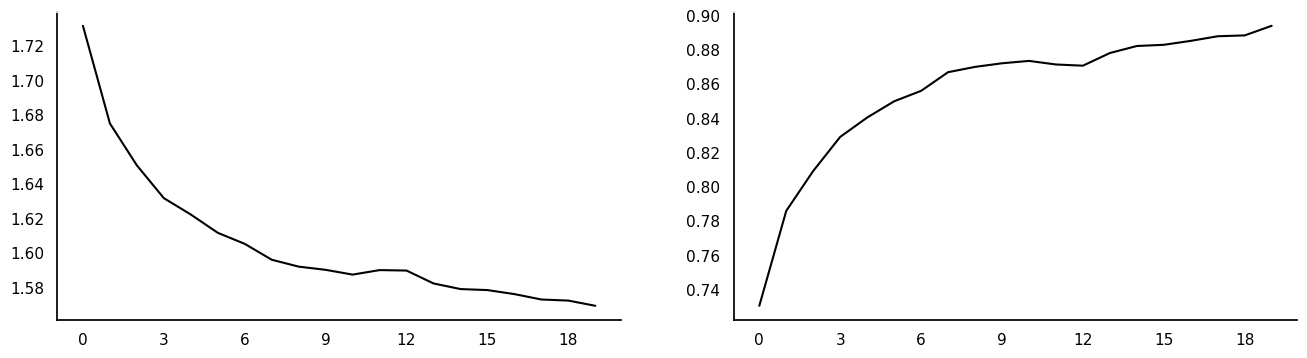

In [444]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(16, 4))

# Set the background color to white
plt.rcParams['figure.facecolor'] = 'white'

# First subplot
plt.subplot(121)
plt.plot(list(range(0, len(global_loss_list))), global_loss_list, color='black')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().set_facecolor('white')  # Set subplot background color to white
plt.gca().spines['bottom'].set_color('black')  # Set x-axis color to black
plt.gca().spines['left'].set_color('black')  # Set y-axis color to black
plt.gca().tick_params(axis='x', colors='black')  # Set x-axis tick color to black
plt.gca().tick_params(axis='y', colors='black')  # Set y-axis tick color to black

# Second subplot
plt.subplot(122)
plt.plot(list(range(0, len(global_acc_list))), global_acc_list, color='black')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().set_facecolor('white')  # Set subplot background color to white
plt.gca().spines['bottom'].set_color('black')  # Set x-axis color to black
plt.gca().spines['left'].set_color('black')  # Set y-axis color to black
plt.gca().tick_params(axis='x', colors='black')  # Set x-axis tick color to black
plt.gca().tick_params(axis='y', colors='black')  # Set y-axis tick color to black

print('Non-IID | total comm rounds', len(global_acc_list))

In [445]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
print(noniid_df)

    global_acc_list                               global_loss_list
0            0.7304  tf.Tensor(1.7314498, shape=(), dtype=float32)
1            0.7859  tf.Tensor(1.6748726, shape=(), dtype=float32)
2            0.8092  tf.Tensor(1.6505852, shape=(), dtype=float32)
3            0.8291  tf.Tensor(1.6315967, shape=(), dtype=float32)
4            0.8404   tf.Tensor(1.622116, shape=(), dtype=float32)
5            0.8499  tf.Tensor(1.6115149, shape=(), dtype=float32)
6            0.8560  tf.Tensor(1.6051118, shape=(), dtype=float32)
7            0.8669  tf.Tensor(1.5959179, shape=(), dtype=float32)
8            0.8700  tf.Tensor(1.5919126, shape=(), dtype=float32)
9            0.8721  tf.Tensor(1.5900614, shape=(), dtype=float32)
10           0.8735  tf.Tensor(1.5872952, shape=(), dtype=float32)
11           0.8714  tf.Tensor(1.5899091, shape=(), dtype=float32)
12           0.8707   tf.Tensor(1.589642, shape=(), dtype=float32)
13           0.8781  tf.Tensor(1.5821719, shape=(), dtype=floa

In [446]:
compute_dp_sgd_privacy

<module 'tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy' from '/usr/local/lib/python3.10/dist-packages/tensorflow_privacy/privacy/analysis/compute_dp_sgd_privacy.py'>

In [447]:
tensorflow_privacy.compute_dp_sgd_privacy(n=X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=10,
                                              delta=1e-5)

(0.35900103412369533, 25.0)

In [448]:
def calculate_metrics(dishonest_predicted, honest_predicted, all_workers):
    total_workers = len(all_workers)
    total_dishonest = sum(1 for client in all_workers if client.endswith('*'))
    # Correctly identified as dishonest
    TP = sum(1 for client in dishonest_predicted if client.endswith('*'))
    # Incorrectly identified as dishonest
    FP = len(dishonest_predicted) - TP
    # Actual dishonest workers not identified as such
    FN = total_dishonest - TP
    # Correctly identified as honest, assumes total_workers is the sum of dishonest and honest workers
    TN = total_workers - total_dishonest - FP

    # Calculating metrics
    accuracy = (TP + TN) / (total_workers) if (total_workers) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (total_dishonest) if (total_dishonest) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score


def calculate_metrics_from_json(data):
  # Ground truth
  dishonest_workers_gt = [client for client in data['dhw'] if client.endswith('*')] + [client for client in data['ahw'] if client.endswith('*')]
  total_dishonest = len(dishonest_workers_gt)

  # Method 1
  accuracy1, precision1, recall1, f1_score1 = calculate_metrics(data['dhw'], data['hw'], data["aw"])

  # Method 2
  accuracy2, precision2, recall2, f1_score2 = calculate_metrics(data['adhw'], data['hw'], data["aw"])

  print("MKRUM - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy1, precision1, recall1, f1_score1))
  print("BIASDETECT - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy2, precision2, recall2, f1_score2))

  return [data["tr"], accuracy1, precision1, recall1, f1_score1, accuracy2, precision2, recall2, f1_score2]


In [449]:
# log_file='/content/drive/MyDrive/kaggle/logs_Method.MULTIKRUM_0.2_2024-03-29 04:00:33.048277.json'

In [450]:
import json

def load_log_file(filename) -> dict:
  run_logs = None
  with open(filename, 'r') as file:
      return json.load(file)

In [451]:
from pandas import DataFrame
import pandas as pd

def calculate_scores(filename):
  logs = load_log_file(filename)
  run_logs = logs['run_logs']
  scores = []
  for data in run_logs:
    round_data = calculate_metrics_from_json(data)
    scores.append(round_data)
  df = DataFrame(scores, columns=['round', 'accuracy1', 'precision1', 'recall1', 'f1_score1', 'accuracy2', 'precision2', 'recall2', 'f1_score2'])
  df = df.iloc[1:, :]
  return df

df = calculate_scores(log_file)

MKRUM - Accuracy: 0.98, Precision: 0.94, Recall: 1.00, F1 Score: 0.97
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.90, Precision: 1.00, Recall: 0.68, F1 Score: 0.81
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.81, Precision: 0.75, Recall: 0.58, F1 Score: 0.65
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.87, Precision: 0.91, Recall: 0.65, F1 Score: 0.75
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.90, Precision: 0.96, Recall: 0.71, F1 Score: 0.81
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.90, Precision: 1.00, Recall: 0.68, F1 Score: 0.81
BIASDETECT - Accuracy: 0.70, Precision: 1.00, Recall: 0.03, F1 Score: 0.06
MKRUM - Accuracy: 0.85, Precision: 1.00, Recall: 0.52, F1 Score: 0.68
BIASDETECT - Accuracy: 0.69, Precision: 0.00, Recall: 0.00, 

In [452]:
df

,round,accuracy1,precision1,recall1,f1_score1,accuracy2,precision2,recall2,f1_score2
1,1,0.898990,1.000000,0.677419,0.807692,0.686869,0.0,0.000000,0.000000
2,2,0.808081,0.750000,0.580645,0.654545,0.686869,0.0,0.000000,0.000000
3,3,0.868687,0.909091,0.645161,0.754717,0.686869,0.0,0.000000,0.000000
4,4,0.898990,0.956522,0.709677,0.814815,0.686869,0.0,0.000000,0.000000
5,5,0.898990,1.000000,0.677419,0.807692,0.696970,1.0,0.032258,0.062500
6,6,0.848485,1.000000,0.516129,0.680851,0.686869,0.0,0.000000,0.000000
7,7,0.838384,1.000000,0.483871,0.652174,0.696970,1.0,0.032258,0.062500
8,8,0.929293,1.000000,0.774194,0.872727,0.696970,1.0,0.032258,0.062500
9,9,0.888889,0.916667,0.709677,0.800000,0.686869,0.0,0.000000,0.000000
10,10,0.848485,0.900000,0.580645,0.705882,0.686869,0.0,0.000000,0.000000


In [453]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

def _plot_series(series, series_name, series_index, series1_key, series2_key, algos):
    palette = list(sns.color_palette('Dark2'))  # Use color_palette instead of mpl_palette
    xs = series['round']  # Assuming 'round' is the column you want on the x-axis
    ys1 = series[series1_key]
    ys2 = series[series2_key]

    # Plot accuracy1
    plt.plot(xs, ys1, label=f'{algos[0]} {series_name}', color=palette[series_index % len(palette)])
    # Plot accuracy2 with a different color
    plt.plot(xs, ys2, label=f'{algos[1]} {series_name}', color=palette[(series_index + 1) % len(palette)])

    # Ensure x-axis only shows integers
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [454]:
def render_plot(title, series1_key, series2_key):
    fig, ax = plt.subplots(figsize=(10, 5.2))
    df_1 = df
    df_sorted = df_1.sort_values('round', ascending=True)

    # Assuming df has columns 'round', 'accuracy1', and 'accuracy2'
    _plot_series(df_sorted, title, 0, series1_key=series1_key, series2_key=series2_key, algos=[MK_CHOICE, 'BD'])

    sns.despine(fig=fig, ax=ax, top=True, right=True, left=False, bottom=False)
    ax.set_xlabel('Round')
    ax.set_ylabel(title)
    legend = ax.legend()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure x-axis only shows integers

    # Set the background color of the plot area to white
    ax.set_facecolor('white')

    # Set the background color of the entire figure to white
    fig.patch.set_facecolor('white')

    # Set the background color of the legend to white
    legend.get_frame().set_facecolor('white')

    # Set the color of the legend frame to black
    legend.get_frame().set_edgecolor('black')

    # Set the color of the axes spines to black
    for spine in ax.spines.values():
        spine.set_color('black')

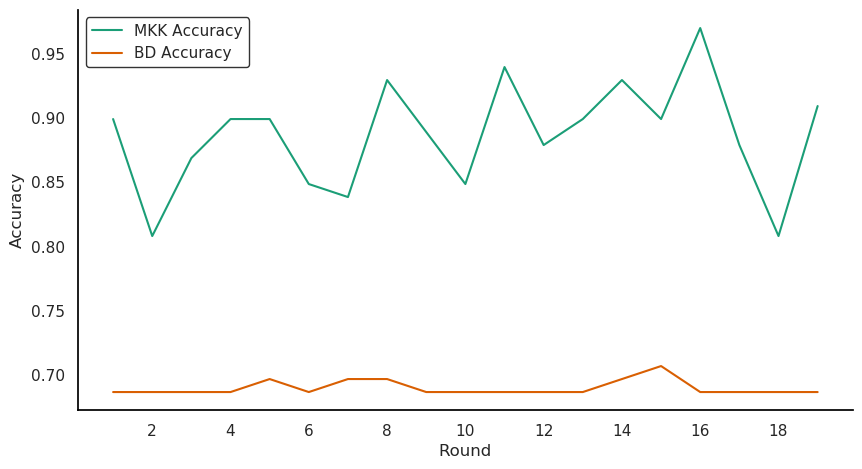

In [455]:
render_plot(title='Accuracy', series1_key='accuracy1', series2_key='accuracy2')

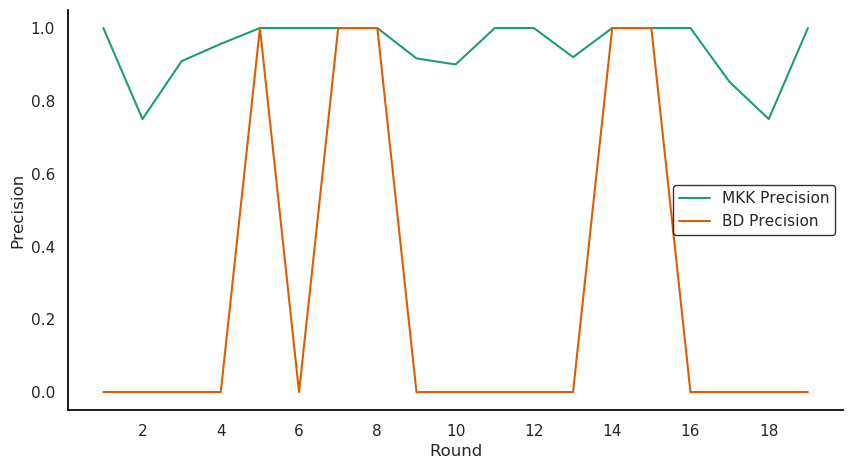

In [456]:
render_plot(title='Precision', series1_key='precision1', series2_key='precision2')

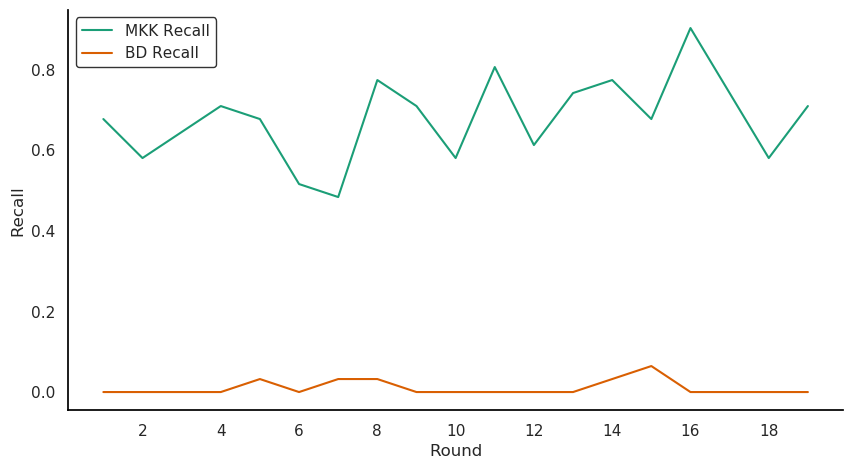

In [457]:
render_plot(title='Recall', series1_key='recall1', series2_key='recall2')

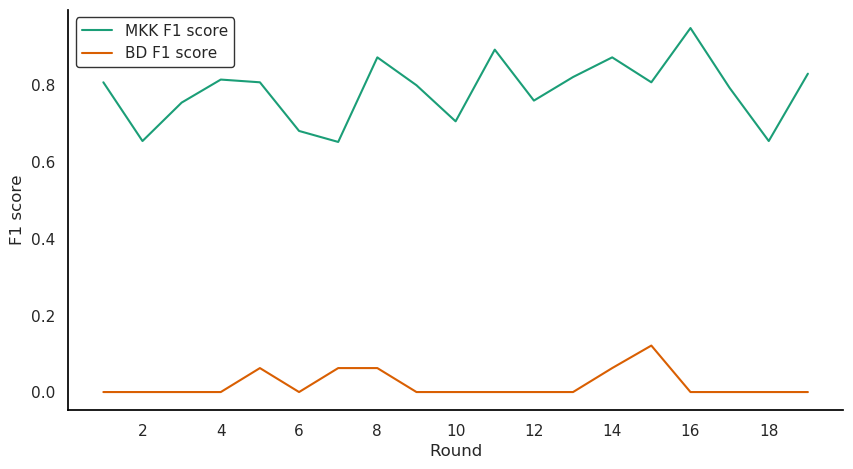

In [458]:
render_plot(title='F1 score', series1_key='f1_score1', series2_key='f1_score2')

In [459]:
import matplotlib.pyplot as plt
import matplotlib

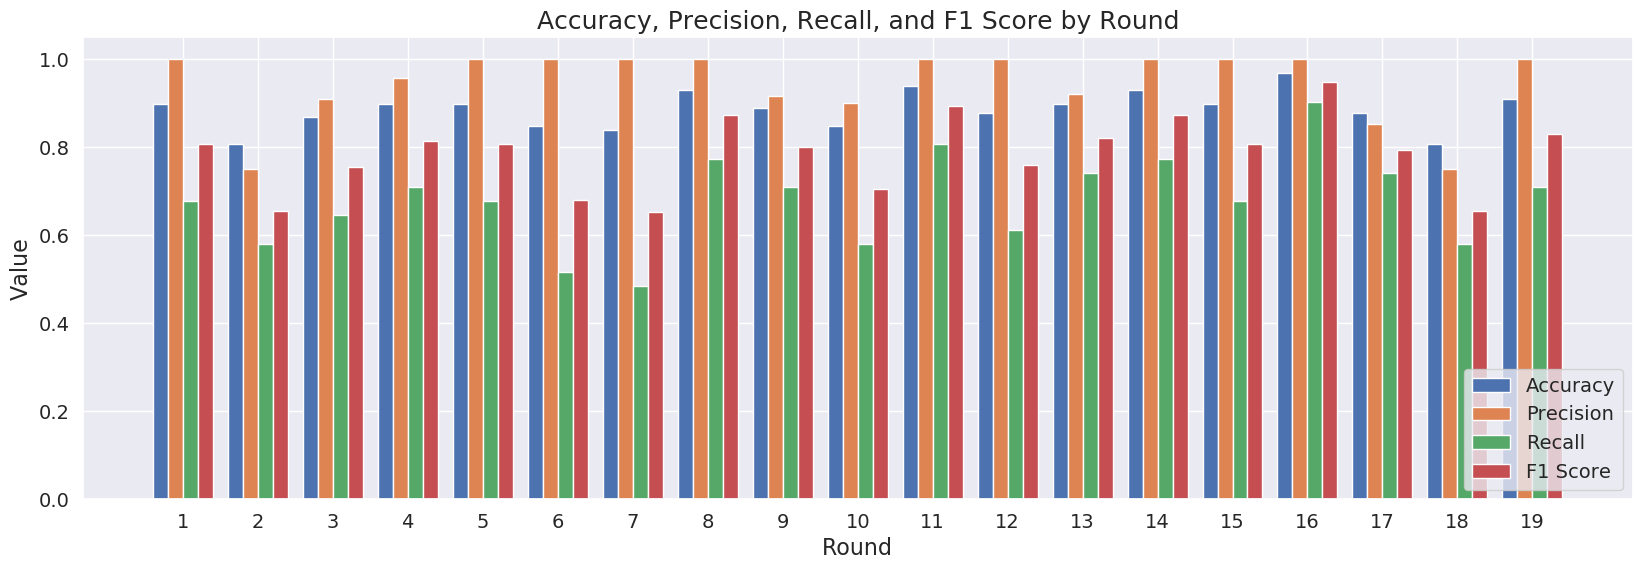

In [460]:
import matplotlib.pyplot as plt
import matplotlib

# Set the default font size for various elements
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18})

# Create a new figure and axis with twice the width
fig, ax = plt.subplots(figsize=(20, 6))

# Set the width of each bar
bar_width = 0.2

# Plot the metrics for series 1
ax.bar(df['round'] - 1.5 * bar_width, df['accuracy1'], width=bar_width, label='Accuracy')
ax.bar(df['round'] - 0.5 * bar_width, df['precision1'], width=bar_width, label='Precision')
ax.bar(df['round'] + 0.5 * bar_width, df['recall1'], width=bar_width, label='Recall')
ax.bar(df['round'] + 1.5 * bar_width, df['f1_score1'], width=bar_width, label='F1 Score')

# Set the labels and title
ax.set_xlabel('Round')
ax.set_ylabel('Value')
ax.set_title('Accuracy, Precision, Recall, and F1 Score by Round')

# Set the x-axis tick positions and labels
rounds = df['round'].unique()
ax.set_xticks(rounds)
ax.set_xticklabels(rounds)

# Add a legend in the bottom right corner
ax.legend(loc='lower right')

# Display the plot
plt.show()

In [461]:
df_mkk = calculate_scores('/content/drive/MyDrive/kaggle/logs_Method.MULTIKRUM_0.2_2024-03-29 04:00:33.048277.json')
df_mk = calculate_scores('/content/drive/MyDrive/kaggle/logs_Method.MULTIKRUM_0.3_2024-03-29 05:09:19.552971.json')

MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.73, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 0.94, Precision: 0.82, Recall: 1.00, F1 Score: 0.90
BIASDETECT - Accuracy: 0.90, Precision: 1.00, Recall: 0.63, F1 Score: 0.77
MKRUM - Accuracy: 0.98, Precision: 0.93, Recall: 1.00, F1 Score: 0.96
BIASDETECT - Accuracy: 0.74, Precision: 1.00, Recall: 0.04, F1 Score: 0.07
MKRUM - Accuracy: 0.98, Precision: 0.93, Recall: 1.00, F1 Score: 0.96
BIASDETECT - Accuracy: 0.89, Precision: 1.00, Recall: 0.59, F1 Score: 0.74
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.92, Precision: 1.00, Recall: 0.70, F1 Score: 0.83
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.73, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.94, Precision: 1.00, Recall: 0.78, 

In [462]:
def merge_dataframes(df_mk, df_mkk):
    # Select the 'round' column and columns with suffix '1' from df_mk and append '_mk'
    df_mk_filtered = df_mk[['round'] + [col for col in df_mk.columns if col.endswith('1')]]
    df_mk_filtered.columns = ['round'] + [col + '_mk' for col in df_mk_filtered.columns if col != 'round']

    # Select columns with suffix '1' from df_mkk and append '_mkk'
    df_mkk_filtered = df_mkk.filter(regex='1$', axis=1)
    df_mkk_filtered.columns = [col + '_mkk' for col in df_mkk_filtered.columns]

    # Merge the filtered dataframes horizontally
    merged_df = pd.concat([df_mk_filtered, df_mkk_filtered], axis=1)

    return merged_df

merged_df = merge_dataframes(df_mk, df_mkk)
merged_df

,round,accuracy1_mk,precision1_mk,recall1_mk,f1_score1_mk,accuracy1_mkk,precision1_mkk,recall1_mkk,f1_score1_mkk
1,1,1.000000,1.000000,1.0,1.000000,0.939394,0.818182,1.0,0.900000
2,2,1.000000,1.000000,1.0,1.000000,0.979798,0.931034,1.0,0.964286
3,3,0.959596,0.897436,1.0,0.945946,0.979798,0.931034,1.0,0.964286
4,4,0.979798,0.945946,1.0,0.972222,1.000000,1.000000,1.0,1.000000
5,5,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
6,6,0.979798,0.945946,1.0,0.972222,1.000000,1.000000,1.0,1.000000
7,7,0.979798,0.945946,1.0,0.972222,0.979798,0.931034,1.0,0.964286
8,8,0.939394,0.853659,1.0,0.921053,1.000000,1.000000,1.0,1.000000
9,9,0.979798,0.945946,1.0,0.972222,1.000000,1.000000,1.0,1.000000
10,10,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000


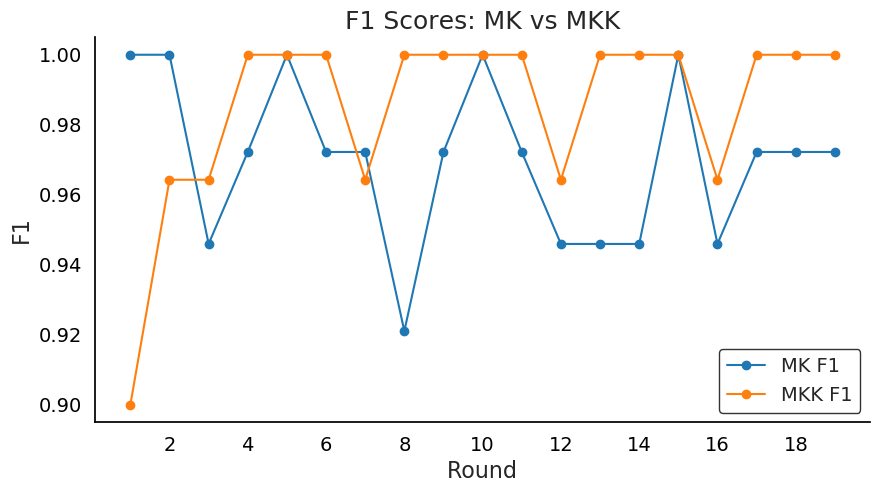

In [464]:
def plot_f1_scores(merged_df):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Set the background color to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Plot f1 scores for MK
    ax.plot(merged_df['round'], merged_df['f1_score1_mk'], marker='o', label='MK F1', color='#1f77b4')

    # Plot f1 scores for MKK
    ax.plot(merged_df['round'], merged_df['f1_score1_mkk'], marker='o', label='MKK F1', color='#ff7f0e')

    # Set the title and labels
    ax.set_title('F1 Scores: MK vs MKK')
    ax.set_xlabel('Round')
    ax.set_ylabel('F1')

    # Set the x-axis to display integers only
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Remove the grid
    ax.grid(False)

    # Set the x and y axis colors to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the x and y axis tick colors to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    # Add a legend with white background and black edges
    legend = ax.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

    plt.show()

plot_f1_scores(merged_df)